In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf

import analysis_functions as af
import stats
import utility as ut

#Can be removed later
import importlib
#

In [2]:
run_number = 15589
folderdata = [f"/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/{run_number}/trg2"]

In [3]:
df = merge_hdfs_multi(folderdata)

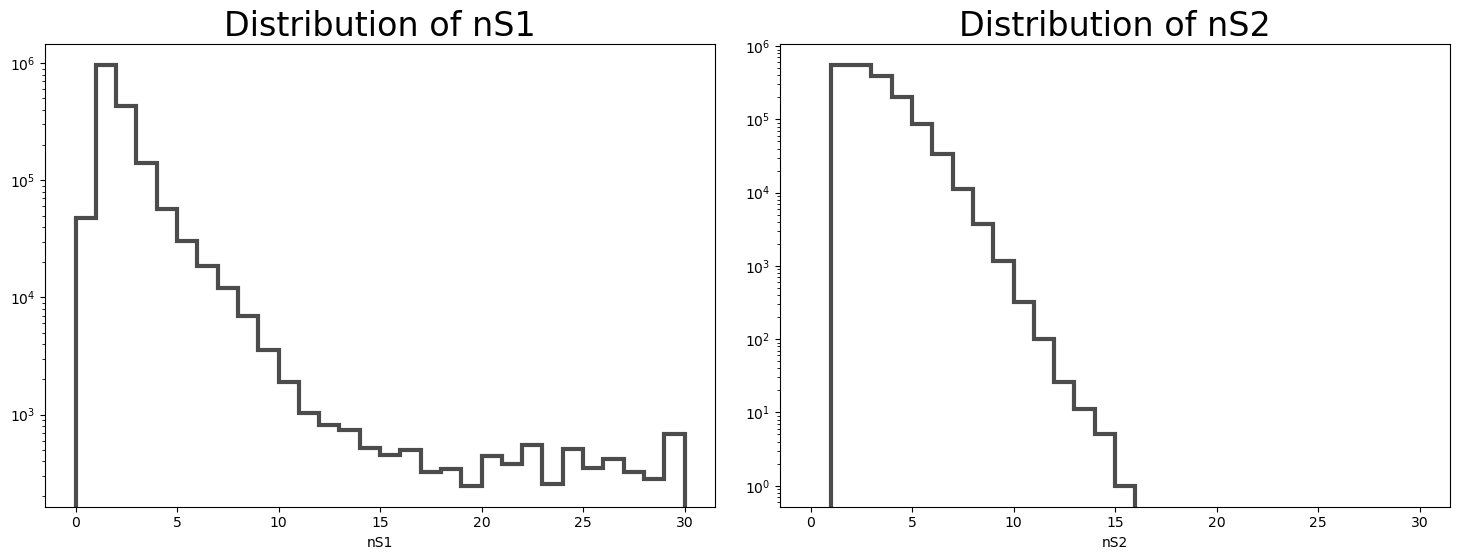

In [4]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
auto_plot_style()

# Plot histogram of df_sel['s1w']
axes[0].hist(df[df['s2_peak']==0]['nS1'], bins=30, range=[0,30], histtype='step', color = color_sequence[0], alpha=0.7)
axes[0].set_xlabel('nS1')
axes[0].set_title('Distribution of nS1')
axes[0].set_yscale('log')

# Plot histogram of df_sel['s1e']
axes[1].hist(df[df['s2_peak']==0]['nS2'], bins=30, range = [0,30], histtype='step',color = color_sequence[0], alpha=0.7)
axes[1].set_xlabel('nS2')
axes[1].set_yscale('log')
axes[1].set_title('Distribution of nS2')

# Adjust layout for better spacing
plt.tight_layout()

In [5]:
df = df.dropna()
df.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

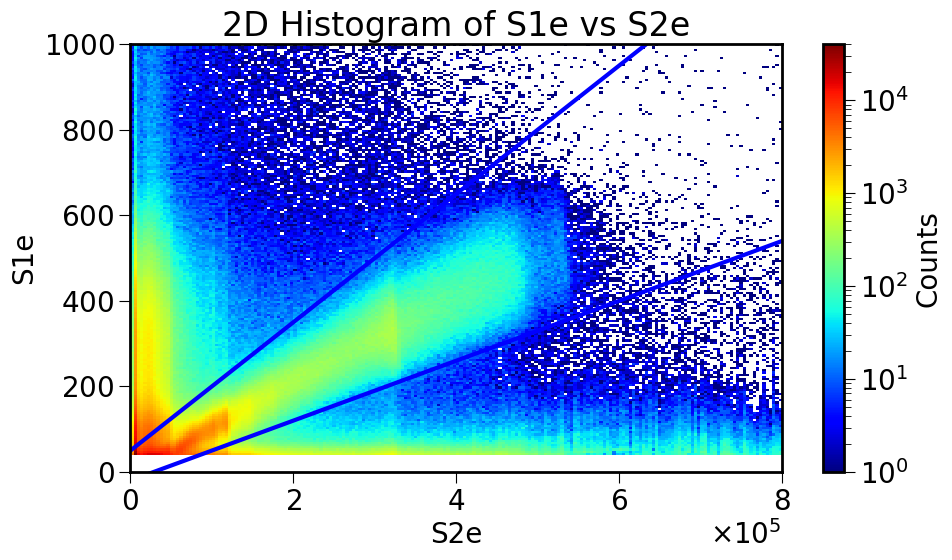

In [6]:
# Define histogram bins
x = df['S1e']
y = df['S2e']

xrange = (0,.8e6)
yrange = (0,1000)

# Compute 2D histogram
H, xedges, yedges = np.histogram2d(y, x, bins=(200,200), range= ( xrange, yrange) )

# Mask zero-count bins
H = np.where(H == 0, np.nan, H)

lineup = ut.line_from_points( 0.,50.,0.4e6,650 )
linedown = ut.line_from_points(0.2e6,120,0.6e6,400)

x_vals = np.linspace(0, 1e6, 1000)

# Evaluate the line at each x
y_vals = linedown(x_vals)

# Plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, H.T, cmap='jet',norm = LogNorm())
plt.plot(x_vals, lineup(x_vals), label='linedown', color='blue')
plt.plot(x_vals, linedown(x_vals), label='linedown', color='blue')
plt.colorbar(label='Counts')
plt.xlabel('S2e')
plt.ylabel('S1e')
plt.xlim(xrange)
plt.ylim(yrange)
plt.title('2D Histogram of S1e vs S2e')
plt.tight_layout()
plt.show()

In [7]:
df_Sprop = df[(df['S1e'] >= linedown(df['S2e'])) & (df['S1e'] <= lineup(df['S2e']))]
print(f"NEvent filtered road : {len(np.unique(df_Sprop['event']))}")
print(f"eff:{(len(np.unique(df_Sprop['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1217044
eff:97.41%


In [8]:
df_Sprop_single_s1s2 = df_Sprop.groupby('time').filter(lambda x: (x['s1_peak'].count() == 1) & (x['s2_peak'].count() == 1))

print(f"NEvent filtered road : {len(np.unique(df_Sprop_single_s1s2['event']))}")
print(f"eff:{(len(np.unique(df_Sprop_single_s1s2['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 814625
eff:65.20%


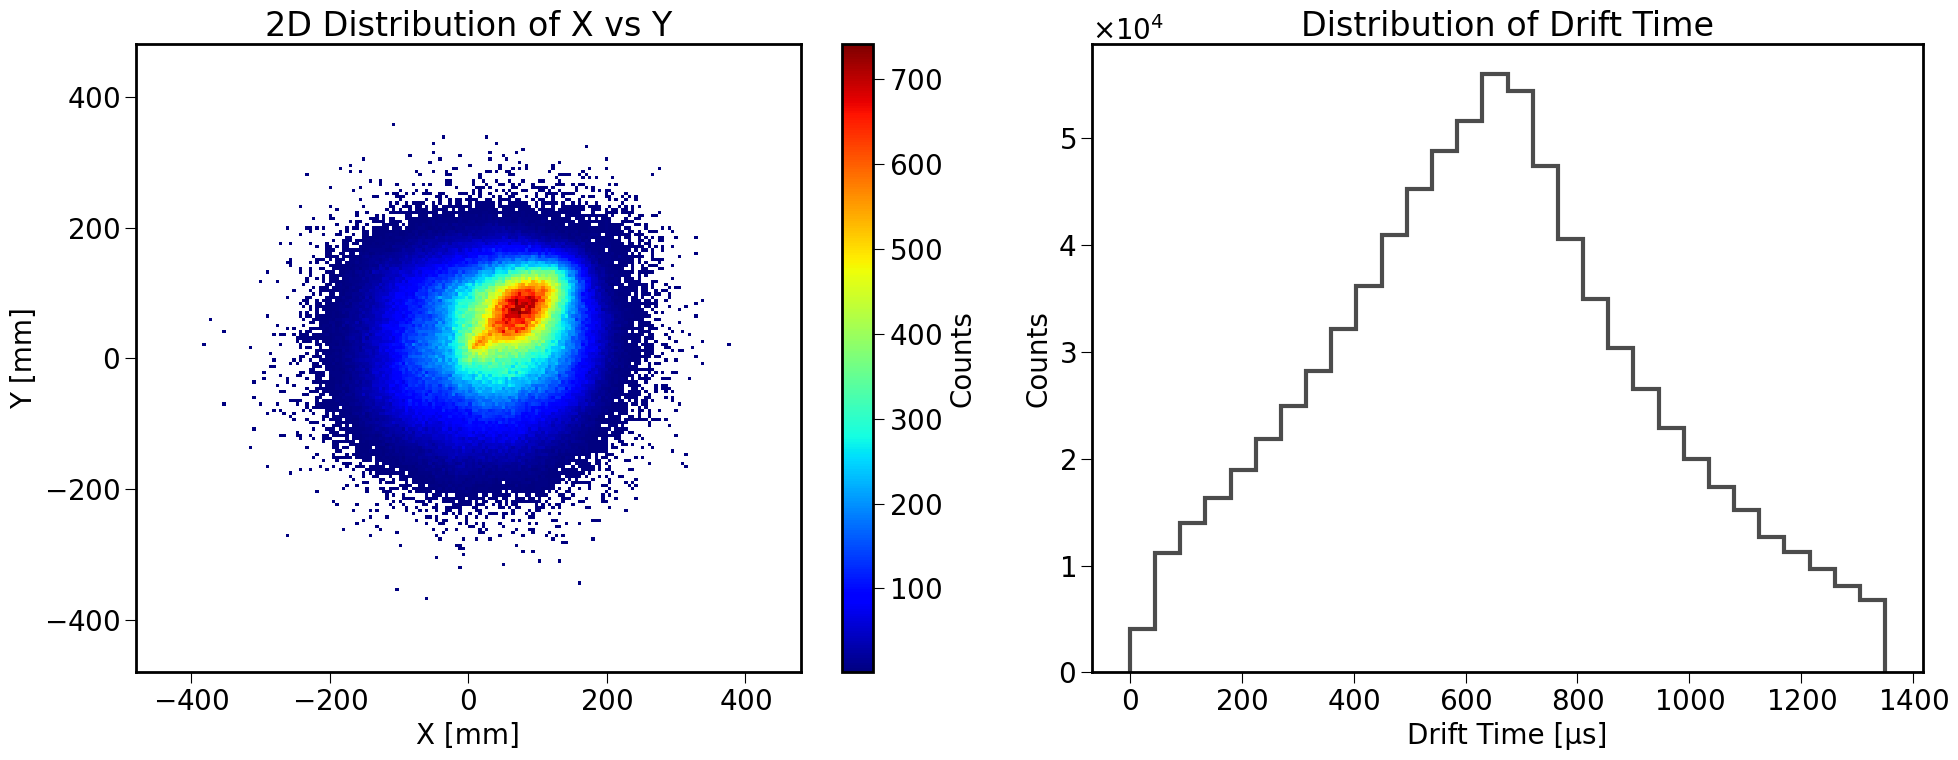

In [9]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
auto_plot_style()  # Assuming this sets fonts and colors

# --- 2D Histogram of X vs Y ---
H, xedges, yedges = np.histogram2d(
    df_Sprop_single_s1s2['X'], df_Sprop_single_s1s2['Y'],
    bins=(200, 200), range=((-480, 480), (-480, 480))
)
H = np.where(H == 0, np.nan, H)  # Mask zero counts

pcm = axes[0].pcolormesh(xedges, yedges, H.T, cmap='jet')
axes[0].set_xlabel('X [mm]')
axes[0].set_ylabel('Y [mm]')
axes[0].set_title('2D Distribution of X vs Y')

# Add colorbar
fig.colorbar(pcm, ax=axes[0], label='Counts')

# --- Histogram of Drift Time (DT) ---
axes[1].hist(
    df_Sprop_single_s1s2['DT'],
    bins=30, range=(0, 1350),
    histtype='step',
    color=color_sequence[0],
    alpha=0.7
)
axes[1].set_xlabel('Drift Time [μs]')
axes[1].set_ylabel('Counts')
axes[1].set_title('Distribution of Drift Time')

# Final layout
plt.tight_layout()
plt.show()

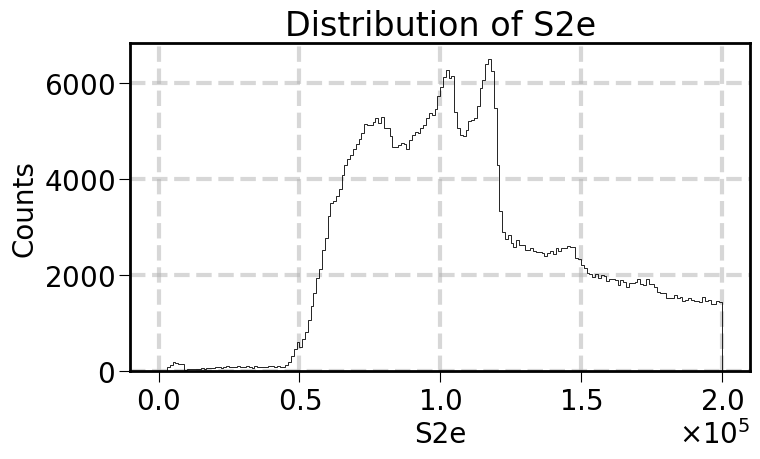

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(df_Sprop_single_s1s2['S2e'], bins=200, range=(0,2e5), histtype='step',linewidth = .6)
plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('Distribution of S2e')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
kr_map = af.load_kr_map('../db/kr_maps/map_run15586.npz')

In [12]:
df_Sprop_single_s1s2_coor = af.correct_S2e(df_Sprop_single_s1s2, kr_map, rmax=400.0, zmax=1350.0)

In [13]:
df_Sprop_single_s1s2_coor[['S2e','Epes','corrections']]

,S2e,Epes,corrections
1,178726.296875,183822.096065,0.972279
4,79689.921875,81095.557558,0.982667
13,88209.726562,90517.872137,0.974501
31,420702.625000,433029.614772,0.971533
32,355397.468750,360235.311350,0.986570
...,...,...,...
4381404,425475.906250,430787.054546,0.987671
4381419,74972.687500,75846.296276,0.988482
4381430,200135.625000,208097.557775,0.961739
4381434,198413.562500,202824.140692,0.978254


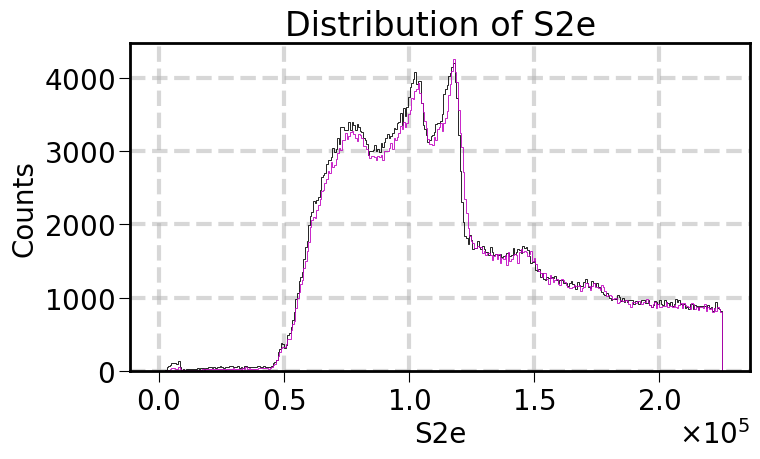

In [24]:
plt.figure(figsize=(8, 5))
plt.hist(df_Sprop_single_s1s2['S2e'], bins=350, range=(0,2.25e5), histtype='step',linewidth = .6)
plt.hist(df_Sprop_single_s1s2_coor['Epes'], bins=350, range=(0,2.25e5), histtype='step',linewidth = .6)
plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('Distribution of S2e')
plt.grid(True)
plt.tight_layout()
plt.show()

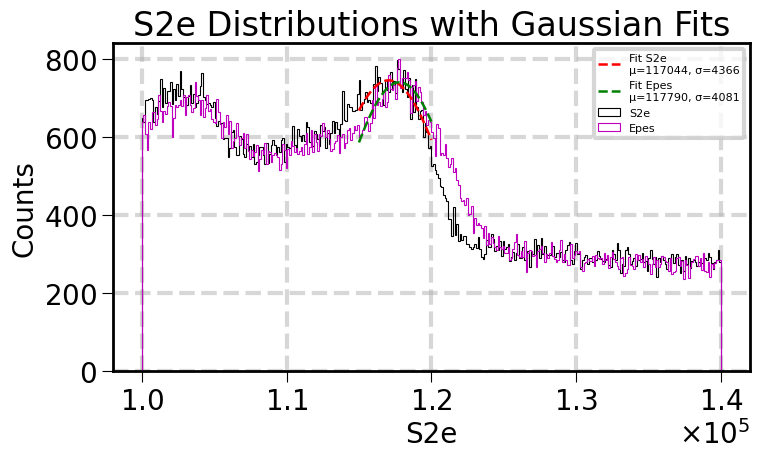

In [39]:
# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Plot range
plot_range = (1e5, 1.4e5)
bins = np.linspace(*plot_range, 351)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Fit range
fit_range = (1.15e5, 1.20e5)
fit_mask = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])

# First histogram (S2e)
counts1, _ = np.histogram(df_Sprop_single_s1s2['S2e'], bins=bins)
popt1, _ = curve_fit(gaussian, bin_centers[fit_mask], counts1[fit_mask],
                     p0=[counts1.max(), bin_centers[np.argmax(counts1)], 3000])

# Second histogram (Epes)
counts2, _ = np.histogram(df_Sprop_single_s1s2_coor['Epes'], bins=bins)
popt2, _ = curve_fit(gaussian, bin_centers[fit_mask], counts2[fit_mask],
                     p0=[counts2.max(), bin_centers[np.argmax(counts2)], 3000])

x = np.linspace(fit_range[0],fit_range[1],500)

# Plot both histograms and fits
plt.figure(figsize=(8, 5))

plt.hist(df_Sprop_single_s1s2['S2e'], bins=bins, histtype='step', linewidth=0.8, label='S2e')
plt.plot(x, gaussian(x, *popt1), 'r--', linewidth=1.8,label=f'Fit S2e\nμ={popt1[1]:.0f}, σ={popt1[2]:.0f}')

plt.hist(df_Sprop_single_s1s2_coor['Epes'], bins=bins, histtype='step', linewidth=0.8, label='Epes')
plt.plot(x, gaussian(x, *popt2), 'g--', linewidth=1.8,label=f'Fit Epes\nμ={popt2[1]:.0f}, σ={popt2[2]:.0f}')

plt.xlabel('S2e')
plt.ylabel('Counts')
plt.title('S2e Distributions with Gaussian Fits')
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()